In [1]:
import string

import dask.diagnostics
import fsspec
import matplotlib.colors
import numpy as np
import proplot
import vcm
import vcm.catalog
import xarray as xr

import metrics
import plotting

In [2]:
plotting.configure_style()

In [3]:
URL = "gs://vcm-ml-experiments/spencerc/2022-07-13-n2f-25-km/post-processed-data-five-years-updated.zarr"
mapper = fsspec.get_mapper(URL)
ds = xr.open_zarr(mapper)
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [4]:
WIND_VARIABLES = [
    "eastward_wind",
    "northward_wind",
    "pressure_thickness_of_atmospheric_layer",
    "air_temperature",
    "specific_humidity"
]
annual_means = metrics.compute_annual_mean(ds)[WIND_VARIABLES]

In [5]:
def zonal_mean_3d(ds, bins):
    ds_on_pressure = vcm.interpolate_to_pressure_levels(
        ds,
        ds.pressure_thickness_of_atmospheric_layer,
        dim="z"
    )
    ds_zonal = vcm.zonal_average_approximate(grid.lat, ds_on_pressure, bins=bins)
    ds_zonal["streamfunction"] = vcm.mass_streamfunction(ds_zonal.northward_wind.rename({"lat": "latitude"})).rename({"latitude": "lat"})
    
    # Proplot won't let me remove this axis label from the plots, so we set it to a blank string
    ds_zonal = ds_zonal.rename({"lat": " "})
    return ds_zonal.assign_coords(pressure=ds_zonal.pressure / 100.0)

The streamfunction is less noisy when we use six-degree wide bins to compute the zonal means.  We stick with two-degree wide bins for other fields.

In [6]:
two_degree_zonal_mean = zonal_mean_3d(annual_means, bins=np.arange(-90, 91, 2))
six_degree_zonal_mean = zonal_mean_3d(annual_means, bins=np.arange(-90, 91, 6))

two_degree_bias = two_degree_zonal_mean - two_degree_zonal_mean.sel(configuration="Fine resolution (year two)")
six_degree_bias = six_degree_zonal_mean - six_degree_zonal_mean.sel(configuration="Fine resolution (year two)")

In [7]:
annual_mean_precip = metrics.compute_annual_mean(ds)[["total_precipitation_rate"]]
zonal_mean_precip = vcm.zonal_average_approximate(grid.lat, annual_mean_precip, bins=np.arange(-90, 91, 2))
precip_bias = zonal_mean_precip - zonal_mean_precip.sel(configuration="Fine resolution (year two)")
precip_bias = precip_bias.rename({"lat": " "})

In [8]:
CONFIGURATIONS = ["Baseline", "ML-corrected seed 1", "Fine resolution (year two)"]

In [9]:
with dask.diagnostics.ProgressBar():
    two_degree_full = two_degree_zonal_mean.sel(climate="Unperturbed", configuration=CONFIGURATIONS).mean("time").compute()
    two_degree_bias = two_degree_bias.sel(climate="Unperturbed", configuration=CONFIGURATIONS).mean("time").compute()
    
    six_degree_full = six_degree_zonal_mean.sel(climate="Unperturbed", configuration=CONFIGURATIONS).mean("time").compute()
    six_degree_bias = six_degree_bias.sel(climate="Unperturbed", configuration=CONFIGURATIONS).mean("time").compute()

[########################################] | 100% Completed |  2min 27.6s
[########################################] | 100% Completed |  2min 34.6s
[########################################] | 100% Completed |  2min 12.5s
[########################################] | 100% Completed |  2min 13.8s


In [10]:
with dask.diagnostics.ProgressBar():
    zonal_mean_precip = zonal_mean_precip.sel(climate="Unperturbed", configuration=CONFIGURATIONS).mean("time").compute()
    precip_bias = precip_bias.sel(climate="Unperturbed", configuration=CONFIGURATIONS).mean("time").compute()

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  3.7s


In [11]:
# Proplot workaround for all black contours
black = matplotlib.colors.ListedColormap(["#000000"])

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/xarray/plot/plot.py:1426: ProplotWarning: Ignoring levels=[-10.    -8.75  -7.5   -6.25  -5.    -3.75  -2.5   -1.25   0.     1.25
   2.5    3.75   5.     6.25   7.5    8.75  10.  ]. Instead using norm=<matplotlib.colors.BoundaryNorm object at 0x7efd1b603550> boundaries.
  primitive = ax.contourf(x, y, z, **kwargs)
/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/xarray/plot/plot.py:1415: ProplotWarning: Ignoring levels=[200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320]. Instead using norm=<matplotlib.colors.BoundaryNorm object at 0x7efd1b17b5e0> boundaries.
  primitive = ax.contour(x, y, z, **kwargs)
/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/xarray/plot/plot.py:1426: ProplotWarning: Ignoring levels=[-10.    -8.75  -7.5   -6.25  -5.    -3.75  -2.5   -1.25   0.     1.25
   2.5    3.75   5.     6.25   7.5    8.75  10.  ]. Instead using norm=<m

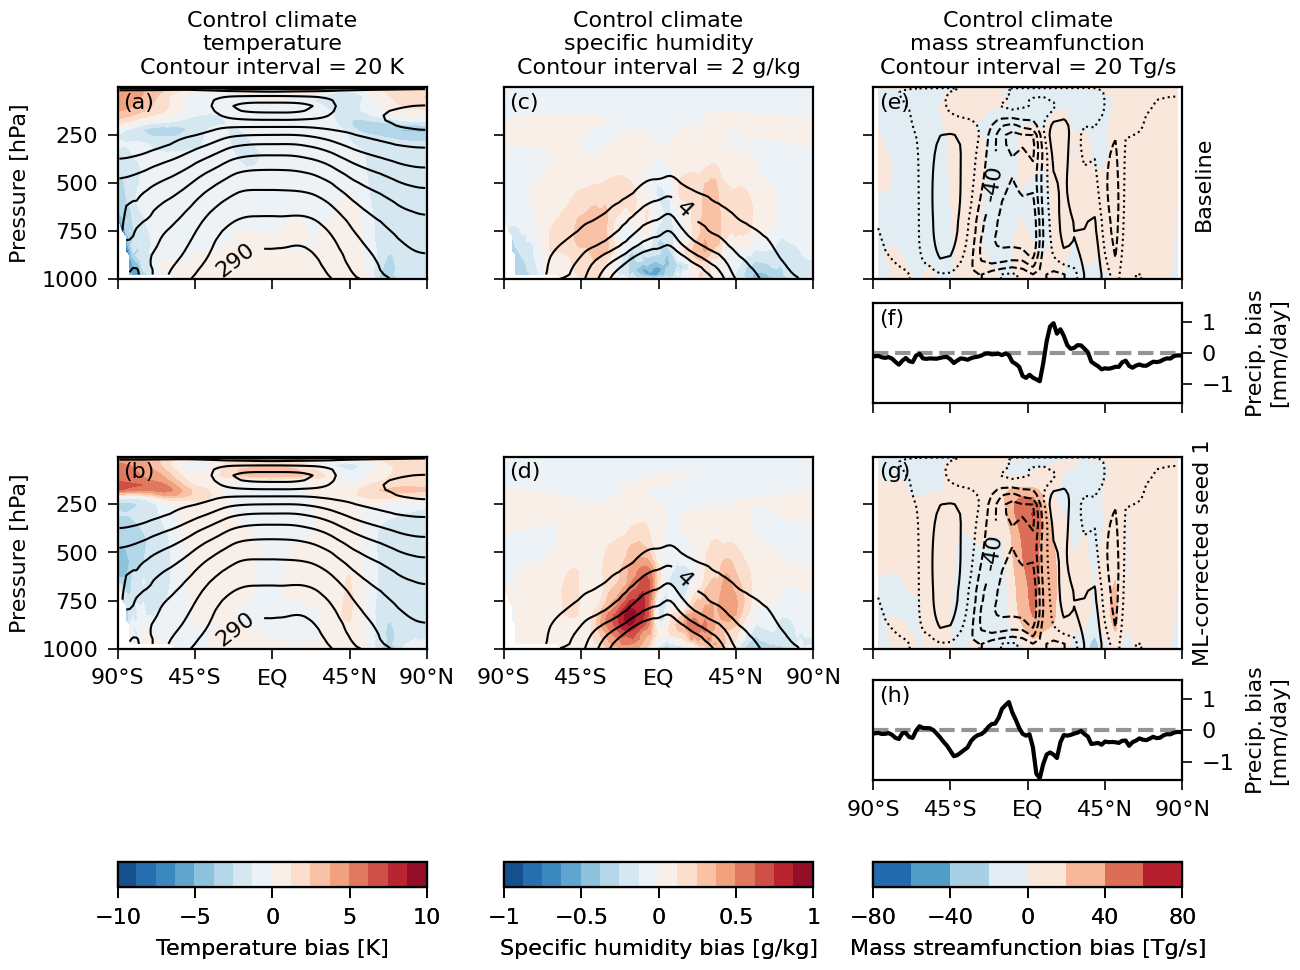

In [12]:
fig, axes = proplot.subplots(ncols=3, nrows=2, refaspect=1/0.618, sharey=False, figwidth=6.5)

x_coord = " "
linewidth = 0.75
G_PER_KG = 1000
SECONDS_PER_DAY = 86400

p1 = two_degree_bias.air_temperature.sel(configuration="Baseline").plot.contourf(
    ax=axes[0],
    x=x_coord,
    y="pressure",
    yincrease=False,
    add_colorbar=False,
    vmin=-10,
    vmax=10,
    levels=17,
    cmap="RdBu_r"
)
cs = two_degree_full.air_temperature.sel(configuration="Fine resolution (year two)").plot.contour(
    ax=axes[0],
    levels=np.arange(200, 321, 10),
    x=x_coord,
    y="pressure",
    yincrease=False,
    cmap=black,
    linewidth=linewidth
)
axes[0].clabel(cs, levels=[290], fmt="%d")
p1 = two_degree_bias.air_temperature.sel(configuration="ML-corrected seed 1").plot.contourf(
    ax=axes[3],
    x=x_coord,
    y="pressure",
    yincrease=False,
    add_colorbar=False,
    vmin=-10,
    vmax=10,
    levels=17,
    cmap="RdBu_r"
)
cs = two_degree_full.air_temperature.sel(configuration="Fine resolution (year two)").plot.contour(
    ax=axes[3],
    levels=np.arange(200, 321, 10),
    x=x_coord,
    y="pressure",
    yincrease=False,
    cmap=black,
    linewidth=linewidth
)
axes[3].clabel(cs, levels=[290], fmt="%d")

p2 = (G_PER_KG * two_degree_bias.specific_humidity).sel(configuration="Baseline").plot.contourf(
    ax=axes[1],
    x=x_coord,
    y="pressure",
    yincrease=False,
    add_colorbar=False,
    vmin=-1,
    vmax=1,
    levels=17,
    cmap="RdBu_r"
)
cs = (G_PER_KG * two_degree_full.specific_humidity).sel(configuration="Fine resolution (year two)").plot.contour(
    ax=axes[1],
    levels=np.arange(0, 10.01, 2.0),
    x=x_coord,
    y="pressure",
    yincrease=False,
    cmap=black,
    linewidth=linewidth
)
axes[1].clabel(cs, levels=[4], fmt="%d")

p2 = (G_PER_KG * two_degree_bias.specific_humidity).sel(configuration="ML-corrected seed 1").plot.contourf(
    ax=axes[4],
    x=x_coord,
    y="pressure",
    yincrease=False,
    add_colorbar=False,
    vmin=-1,
    vmax=1,
    levels=17,
    cmap="RdBu_r"
)
cs = (G_PER_KG * two_degree_full.specific_humidity).sel(configuration="Fine resolution (year two)").plot.contour(
    ax=axes[4],
    levels=np.arange(0, 10.01, 2.0),
    x=x_coord,
    y="pressure",
    yincrease=False,
    cmap=black,
    linewidth=linewidth
)
axes[4].clabel(cs, levels=[4], fmt="%d")


p3 = six_degree_bias.streamfunction.sel(configuration="Baseline").plot.contourf(
    ax=axes[2],
    x=x_coord,
    y="pressure",
    yincrease=False,
    add_colorbar=False,
    levels=np.arange(-80, 81, 20),
    cmap="RdBu_r"
)
cs = six_degree_full.streamfunction.sel(configuration="Fine resolution (year two)").plot.contour(
    ax=axes[2],
    x=x_coord,
    y="pressure",
    yincrease=False,
    cmap=black,
    levels=np.arange(-80, 81, 20),
    linestyles=4 * ["--"] + [":"] + 4 * ["-"],
    linewidth=linewidth
)
axes[2].clabel(cs, levels=[-40], fmt="%d")
px1 = axes[2].panel_axes("bottom", width=0.5, pad=0)
px1.axhline(0, ls="--", color="gray")
(SECONDS_PER_DAY * precip_bias.total_precipitation_rate).sel(configuration="Baseline").plot(ax=px1, x=x_coord, color="k")
px1.set_ylim(-1.6, 1.6)
px1.set_title("")
px1.yaxis.tick_right()
px1.yaxis.set_label_position("right")
px1.set_ylabel("Precip. bias\n[mm/day]")

p3 = six_degree_bias.streamfunction.sel(configuration="ML-corrected seed 1").plot.contourf(
    ax=axes[5],
    x=x_coord,
    y="pressure",
    yincrease=False,
    add_colorbar=False,
    levels=np.arange(-80, 81, 20),
    cmap="RdBu_r"
)
cs = six_degree_full.streamfunction.sel(configuration="Fine resolution (year two)").plot.contour(
    ax=axes[5],
    x=x_coord,
    y="pressure",
    yincrease=False,
    cmap=black,
    levels=np.arange(-80, 81, 20),
    linestyles=4 * ["--"] + [":"] + 4 * ["-"],
    linewidth=linewidth
)
axes[5].clabel(cs, levels=[-40], fmt="%d")

px2 = axes[5].panel_axes("bottom", width=0.5, pad=0)
px2.axhline(0, ls="--", color="gray")
(SECONDS_PER_DAY * precip_bias.total_precipitation_rate).sel(configuration="ML-corrected seed 1").plot(ax=px2, x=x_coord, color="k")
px2.set_ylim(-1.6, 1.6)
px2.set_title("")
px2.set_xlabel(" ")
px2.yaxis.tick_right()
px2.set_ylabel("Precip. bias\n[mm/day]")
px2.yaxis.set_label_position("right")
axes[5].xaxis.set_label("")
axes[5].set_xlabel("")

for ax in [axes[0], axes[1], axes[3], axes[4]]:
    _ = ax.panel_axes("bottom", width=0.5, pad=0, share=False)
    _.set_visible(False)

axes[3].colorbar(p1, loc="bottom", width=0.125, label="Temperature bias [K]")
axes[4].colorbar(p2, loc="bottom", width=0.125, label="Specific humidity bias [g/kg]")
axes[5].colorbar(p3, loc="bottom", width=0.125, label="Mass streamfunction bias [Tg/s]")

for ax, letter in zip([axes[0], axes[1], axes[3], axes[4]], string.ascii_lowercase):
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Pressure [hPa]")
    ax.set_xlim(-90, 90)
    ax.set_xticks(np.array([-90, -45, 0, 45, 90]))
    ax.set_xticklabels([u"90°S", u"45°S", u"EQ", u"45°N", u"90°N"])

for ax, letter in zip([axes[2], axes[5]], string.ascii_lowercase):
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Pressure [hPa]")
    ax.set_xlim(-90, 90)
    ax.set_xticks(np.array([-90, -45, 0, 45, 90]))
    ax.set_xticklabels([u"90°S", u"45°S", u"EQ", u"45°N", u"90°N"])
    
axes[0].annotate(f"(a)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
axes[1].annotate(f"(c)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
axes[2].annotate(f"(e)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
axes[3].annotate(f"(b)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
axes[4].annotate(f"(d)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
axes[5].annotate(f"(g)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
px1.annotate(f"(f)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")
px2.annotate(f"(h)", xy=(0, 1), xytext=(2, -2), va="top", xycoords="axes fraction", textcoords="offset points")

axes[0].set_title("Control climate\ntemperature\nContour interval = 20 K")
axes[1].set_title("Control climate\nspecific humidity\nContour interval = 2 g/kg")
axes[2].set_title("Control climate\nmass streamfunction\nContour interval = 20 Tg/s")

for ax in [axes[1], axes[2], axes[4], axes[5]]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel("Baseline")

axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel("ML-corrected seed 1")

fig.savefig("figures/figure-13.png", dpi=200)
fig.savefig("figures/figure-13.pdf")